### Install Packages

Install required packages and load dependencies.

In [ ]:
!pip install visualkeras
!pip install keras-tuner
!pip install tensorboard

In [ ]:
%load_ext tensorboard

### Connect to google drive [if training on Google Colab]

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Import libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import keras_tuner as kt

### Define constants

A fixed seed is used to make result reproducable and avoid wierd problems while debugging.

Batch size of 32 and 64 is tested and batch size of 64 performed better. Greater batch sizes will crash the notebook because of the RAM usage.

In [ ]:
base_dir = '.'

seed = 1789
shuffle = True

batch_size = 64

validation_split = 0.15

img_height = 150
img_width = 150
image_size=(img_height, img_width)

## Load data

### Unzip and check data

In [ ]:
import zipfile

# Unzip data
zf = zipfile.ZipFile(f"{base_dir}/dk-dataset.zip")
zf.extractall(base_dir)

dataset_path = f"{base_dir}/dataset"

# Check that data is correctly unzipped
data_dir = pathlib.Path(dataset_path)

for sub_dir in os.listdir(data_dir):
    if not sub_dir.startswith('.'):
        print('  - ' + sub_dir + os.path.sep)

  - test/
  - train/


### Download and prepare the dataset

This dataset contains 8582 images from items on Digikala. Half of the images have watermarks, and the other half don't.

We will split the dataset into train and validation sets.

In [ ]:
train_dir = pathlib.Path(f'{dataset_path}/train')

def get_dataset_and_classes(validation_split, batch_size, image_size):
  train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    shuffle=shuffle,
    image_size=image_size,
    batch_size=batch_size)

  val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    shuffle=shuffle,
    image_size=image_size,
    batch_size=batch_size)

  class_names = train_ds_raw.class_names
  print("class names:", class_names)

  AUTOTUNE = tf.data.AUTOTUNE

  train_ds = train_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)

  return train_ds, val_ds, class_names

In [ ]:
train_ds, val_ds, class_names = get_dataset_and_classes(validation_split, batch_size, image_size)

Found 8582 files belonging to 2 classes.
Using 7295 files for training.
Found 8582 files belonging to 2 classes.
Using 1287 files for validation.
class names: ['negative', 'positive']


### Verify the data

We will plot nine samples from the dataset with the corresponding labels to verify the dataset.

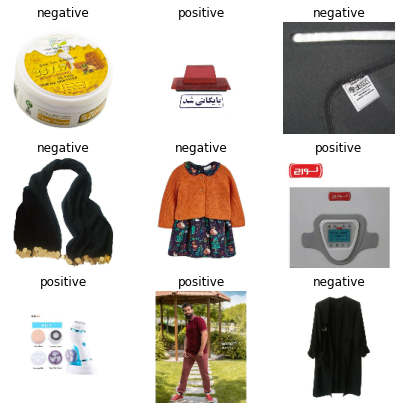

In [ ]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Normalization layer**

Here we check that rescaling layer will work correctly on images.

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

image_batch, labels_batch = next(iter(train_ds))
print("pixel ranges before normalization:", np.min(image_batch[0]), np.max(image_batch[0]))

train_ds_normalized = train_ds.take(1).map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_ds_normalized))
print("pixel ranges after normalization:", np.min(image_batch[0]), np.max(image_batch[0]))

pixel ranges before normalization: 0.0 255.0
pixel ranges after normalization: 0.0 1.0


**Augmentation layer**

In this part we check how augmentation layer will change images.

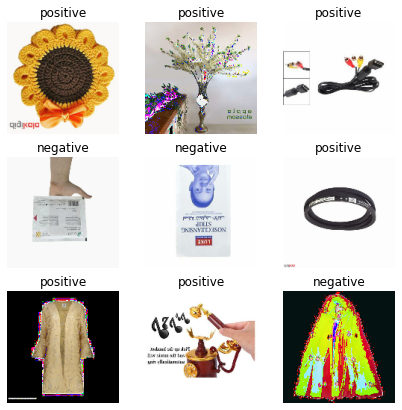

In [ ]:
augmentation_layer = tf.keras.Sequential([
  tf.keras.layers.RandomFlip(),
  tf.keras.layers.RandomContrast(0.2),
])

plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augmentation_layer(images[i])
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


## Create Model

### Define Load and Save model functions

We will define `save_model` and `load_model` functions, so we can save the model and reload it in case of crashing in colab.

In [ ]:
from datetime import datetime

model_base_dir = f'{base_dir}/models'

def save_model(model, file_name=None):
  if not file_name:
    file_name = datetime.now().strftime("%y-%m-%d-%H-%M")

  model.save(f'{model_base_dir}/{file_name}')

def load_model(file_name):
  model = load_model(f'{model_base_dir}/{file_name}')
  return model

### Define Model

In the `build_model` function, the model is defined and compiled.

We can divide the layers into four parts:

1. Preprocessing: \\
 Rescaling layer used in this part to rescale output ranges from [0, 255] to [0, 1].

2. Augmentation: \\
 To avoid overfitting, RandomFlip and RandomContrast layers are used. The factor of random contrast will be tuned.

3. Convolutional base: \\
The base consists of Conv-Pool-Conv-Pool and Conv-Conv-Pool-Conv-Conv-Pool patterns. \\
In the first layers, smaller filters are used to gather local features. As we go to the upper layers, the filter size gradually increases to represent more global and high-level information. \\
Similarly, the number of channels is low in the beginning and will gradually increase.  \\
BatchNorm and Dropout layers are used to avoid overfitting.
Dropout factor will be tuned and there is also possibility of not using dropout at all.

4. Head: \\
After the base of CNN, the units are flattened, and two dense layers are used to classify images.

After defining the model, it will be compiled. Binary Crossentropy is used as loss function, and we will monitor accuracy, number of false positives, and number of false negatives in our metrics.

"Adam" and "SGD" optimizer is tested using hyperparameter tuning and Adam is choosen since it performed better.

In [ ]:
from tensorflow.keras import layers, models


def build_model(hp):
  
  inputs = tf.keras.Input(shape=image_size + (3,))
  
  # Augmentation
  x = layers.RandomContrast(hp.Float('contrast', 0.1, 0.8, sampling='linear', default=0.4))(inputs)
  x = layers.RandomFlip()(x)

  # Preprocessing
  x = layers.Rescaling(1./255)(x)

  # Block 1
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
  x = layers.MaxPooling2D()(x)

  # Block 2
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(hp.Float('dropout_block2', 0, 0.5, sampling='linear', default=0))(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
  x = layers.MaxPooling2D()(x)

  # Block 3
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(hp.Float('dropout_block3', 0, 0.5, sampling='linear', default=0))(x)
  x = layers.Conv2D(filters=128, kernel_size=5, activation='relu', padding='same')(x)
  x = layers.MaxPooling2D()(x)

  # Block 4
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(hp.Float('dropout_block4', 0, 0.5, sampling='linear', default=0))(x)
  x = layers.Conv2D(filters=256, kernel_size=7, activation='relu', padding='same')(x)
  x = layers.Conv2D(filters=256, kernel_size=7, activation='relu', padding='same')(x)
  x = layers.MaxPooling2D()(x)

  flattening_type = hp.Choice("flattening_type", ["flattening", "max_pooling"])

  if flattening_type == "flattening":
    x = layers.Flatten()(x)
  else:
    x = layers.GlobalMaxPooling2D()(x)

  # Head
  x = layers.Dense(hp.Int(f"dense_units_1", 8, 128, step=32, default=8), activation='relu')(x)
  x = layers.Dense(hp.Int(f"dense_units_2", 8, 128, step=32, default=8), activation='relu')(x)
  outputs = layers.Dense(1)(x)

  model = tf.keras.Model(inputs, outputs)

  optimizer_type = hp.Choice("optimizer", ["adam", "sgd"],  default="adam")

  if optimizer_type == "adam":
    optimizer=tf.keras.optimizers.Adam(
      learning_rate=hp.Float('adam_learning_rate', 3e-4, 1, sampling='log', default=1e-3),
      beta_1=hp.Float('adam_beta_1', 0.9, 1, sampling='log', default=0.9),
      beta_2=hp.Float('adam_beta_2', 0.9, 1, sampling='log', default=0.999),
      name='Adam',
      )
  else:
    nesterov = hp.Choice("sgd_nesterov", ["True", "False"])
    optimizer=tf.keras.optimizers.SGD(
      learning_rate=hp.Float('sgd_learning_rate', 3e-4, 1, sampling='log', default=1e-2),
      momentum=hp.Float('sgd_momentum', 0, 1, sampling='log', default=0),
      nesterov=(nesterov == "True"),
      name='SGD',
    )
    
  model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
  )

  return model

### Model Summary

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 random_contrast_14 (RandomC  (None, 150, 150, 3)      0         
 ontrast)                                                        
                                                                 
 random_flip_14 (RandomFlip)  (None, 150, 150, 3)      0         
                                                                 
 rescaling_14 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 batch_normalization_56 (Bat  (None, 150, 150, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_70 (Conv2D)          (None, 150, 150, 32)      896

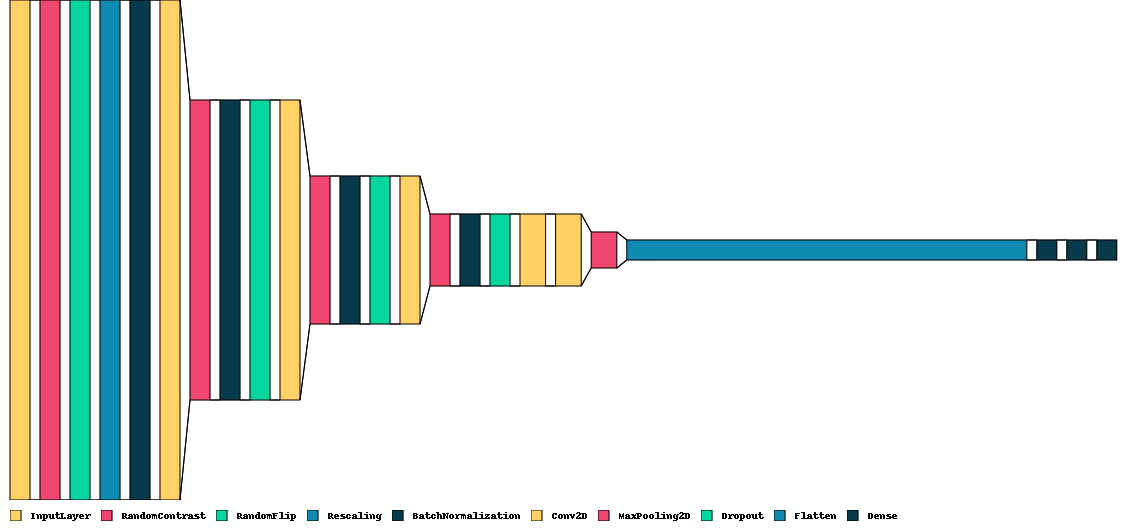

In [ ]:
from keras.utils.vis_utils import plot_model

hp = kt.HyperParameters()

model = build_model(hp)
model.summary()

import visualkeras
visualkeras.layered_view(model, draw_volume=False, legend=True, max_xy=500)

## Train

### Overfitting model on one batch

We will train the model on one batch of the dataset and check whether it can overfit this one batch to make the presence of bugs in our code less likely.

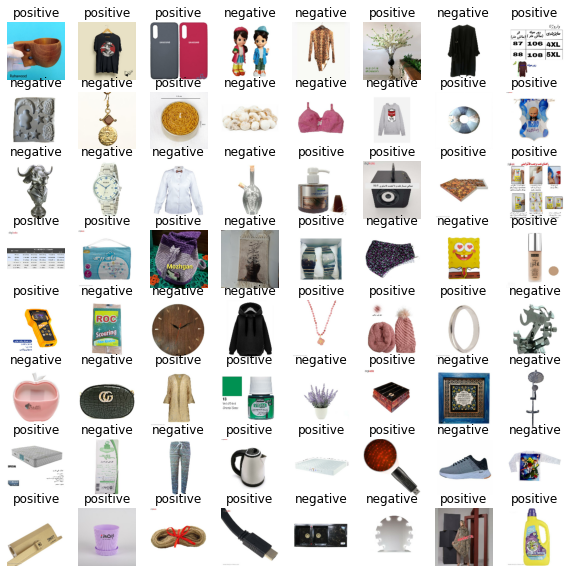

In [ ]:
train_batch_images, train_batch_labels = next(iter(train_ds))
train_batch_images.shape, train_batch_labels.shape

plt.figure(figsize=(10, 10))
for i in range(64):
  ax = plt.subplot(8, 8, i + 1)
  plt.imshow(train_batch_images[i].numpy().astype("uint8"))
  plt.title(class_names[train_batch_labels[i]])
  plt.axis("off")

In [ ]:
hp = kt.HyperParameters()

model = build_model(hp)

history = model.fit(
  x=train_batch_images,
  y=train_batch_labels,
  validation_data=(train_batch_images, train_batch_labels),
  epochs=50
)

Epoch 1/50
2/2 [==============================] - 0s 290ms/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 0.4673 - val_accuracy: 0.8594
Epoch 2/50
2/2 [==============================] - 0s 240ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.2996 - val_accuracy: 0.9062
Epoch 3/50
2/2 [==============================] - 0s 222ms/step - loss: 0.0357 - accuracy: 0.9844 - val_loss: 0.0997 - val_accuracy: 0.9688
Epoch 4/50
2/2 [==============================] - 0s 225ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0670 - val_accuracy: 0.9844
Epoch 5/50
2/2 [==============================] - 0s 237ms/step - loss: 0.0228 - accuracy: 0.9844 - val_loss: 0.0404 - val_accuracy: 0.9844
Epoch 6/50
2/2 [==============================] - 0s 229ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0414 - val_accuracy: 0.9844
Epoch 7/50
2/2 [==============================] - 0s 221ms/step - loss: 0.0167 - accuracy: 0.9844 - val_loss: 0.0755 - val_accuracy: 0.9688
Epoch 8/50
2/2 [====

In [ ]:
model.evaluate(train_batch_images, train_batch_labels)

2/2 [==============================] - 0s 41ms/step - loss: 0.0215 - accuracy: 0.9844


[0.021460646763443947, 0.984375]

### Hyperparameter tuning

The keras tuner BayesianOptimization is used for hyperparameter tuning since it is more efficient than random search.

In [ ]:
base_log_dir = f'{base_dir}/logs' 
base_log_dir

In [ ]:
hp = kt.HyperParameters()
hp.Fixed("optimizer", value="adam")
hp.Fixed("adam_beta_1", value=0.9)
hp.Fixed("adam_beta_2", value=0.999)

tuner = kt.BayesianOptimization(
    build_model,
    hyperparameters=hp,
    tune_new_entries=True,
    max_trials=20,
    # overwrite=True,
    objective="val_accuracy",
    directory=base_log_dir+ '/hp'
)

In [ ]:
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[
               tf.keras.callbacks.TensorBoard(base_log_dir+ '/tuner'), 
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
               ],
)

Trial 20 Complete [00h 06m 08s]
val_accuracy: 0.8749029040336609

Best val_accuracy So Far: 0.8772338628768921
Total elapsed time: 01h 48m 48s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model = tuner.get_best_models()[0]
save_model(best_model)

best_hps = tuner.get_best_hyperparameters(1)[0]
best_hps.values

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/dk-watermark/star/models/22-04-22-00-58/assets


{'adam_beta_1': 0.9,
 'adam_beta_2': 0.999,
 'adam_learning_rate': 0.0003,
 'contrast': 0.1,
 'dense_units_1': 104,
 'dense_units_2': 104,
 'dropout_block2': 0.0,
 'dropout_block3': 0.0,
 'dropout_block4': 0.0,
 'flattening_type': 'flattening',
 'optimizer': 'adam'}

After finding best hyperparameters based on validation data, we will fit the model with these hyperparameters for more epochs. Early stopping is used to avoid overfitting. 

In [ ]:
model = tuner.hypermodel.build(best_hps)
# model = build_model(best_hps)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=base_log_dir + "/fit", histogram_freq=1)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50,
  callbacks=[
             early_stop,
             tensorboard_callback
             ],
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
114/114 [==============================] - 27s 222ms/step - loss: 0.6490 - accuracy: 0.6229 - val_loss: 0.7304 - val_accuracy: 0.5221
Epoch 2/50
114/114 [==============================] - 24s 212ms/step - loss: 0.4065 - accuracy: 0.8192 - val_loss: 0.9352 - val_accuracy: 0.5253
Epoch 3/50
114/114 [==============================] - 24s 211ms/step - loss: 0.3744 - accuracy: 0.8344 - val_loss: 0.6026 - val_accuracy: 0.6449
Epoch 4/50
114/114 [==============================] - 24s 210ms/step - loss: 0.3577 - accuracy: 0.8447 - val_loss: 0.4062 - val_accuracy: 0.8135
Epoch 5/50
114/114 [==============================] - 24s 211ms/step - loss: 0.3400 - accuracy: 0.8585 - val_loss: 0.3603 - val_accuracy: 0.8322
Epoch 6/50
114/114 [==============================] - 24s 210ms/step - loss: 0.3275 - accuracy: 0.8657 - val_loss: 0.3397 - val_accuracy: 0.8648
Epoch 7/50
114/114 [==============================] - 24s 210ms/step - loss: 0.3114 - accuracy: 0.8757 - val_loss: 0.3404 - val_ac

In [ ]:
save_model(model)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/dk-watermark/star/models/22-04-22-01-24/assets


Upload logs to tensorboard to visualize metrics and hyperparameter tuning.

In [ ]:
!tensorboard dev upload \
  --logdir log/2 \
  --name "Watermark Digikala Final" \
  --description "" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/hX1Ln9sVSrSkc7rWCqBX1w/

[2022-04-22T01:13:43] Started scanning logdir.
E0422 01:13:45.190402 139736752342912 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
[2022-04-22T01:14:06] Total uploaded: 1344 scalars, 712 tensors (482.6 kB), 21 binary objects (2.6 MB)
Total skipped: 1 binary objects (127.0 kB)
[2022-04-22T01:14:06] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/hX1Ln9sVSrSkc7rWCqBX1w/


### Tensorboard Link

https://tensorboard.dev/experiment/hX1Ln9sVSrSkc7rWCqBX1w/

### Visualize metrics

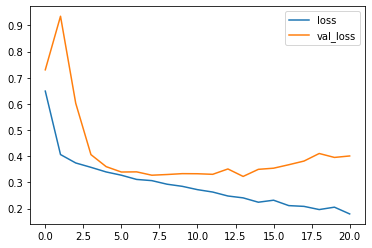

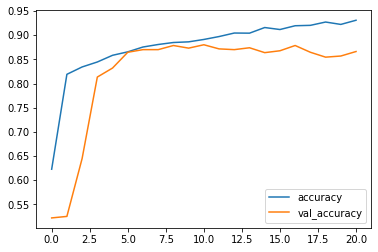

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

def get_labels_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[1], tfdataset))
    if not batched:
        return tf.concat(labels, axis=0)
    return labels

labels_list = get_labels_from_tfdataset(val_ds)

preds_list_raw = model.predict(val_ds)


In [ ]:
threshold=0.5

preds_list = preds_list_raw >= threshold
tn, fp, fn, tp = confusion_matrix(labels_list, preds_list).ravel()
accuracy = accuracy_score(labels_list, preds_list)
                          
print("accuracy:", accuracy)
print("false positive:", fp)
print("false negative:", fn)
print("true positive:", tp)
print("true negative:", tn)


accuracy: 0.8663558663558664
false positive: 44
false negative: 128
true positive: 487
true negative: 628


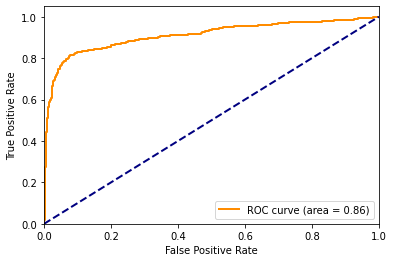

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = roc_auc_score(labels_list, preds_list)

fpr, tpr, thresholds = roc_curve(labels_list, preds_list_raw)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")  # FP / (FP + TN)
plt.ylabel("True Positive Rate")  # TP / (TP + FN)
plt.legend(loc="lower right")
plt.show()


### Visualize feature maps

We will use `show_feature_maps` function to visualize our model and have a better understanding of what it is doing.


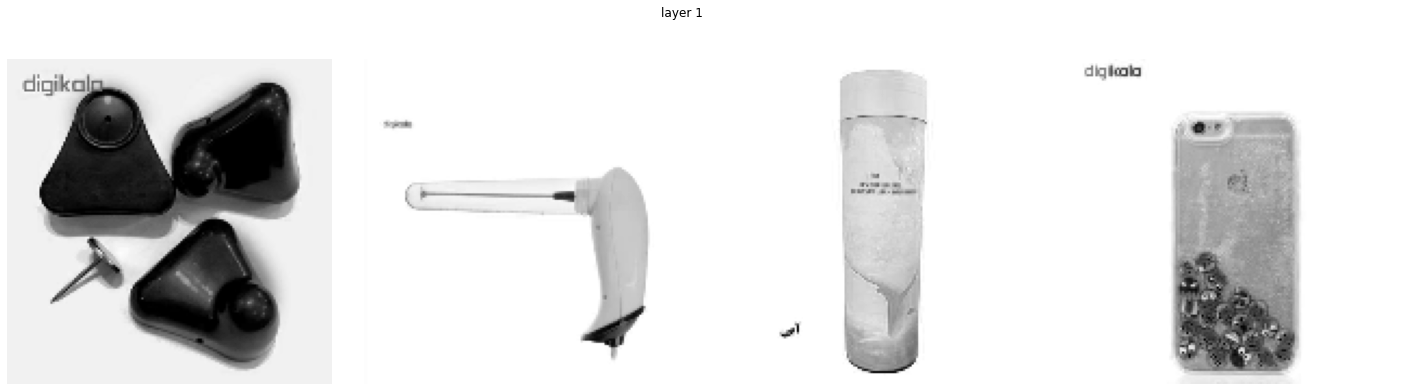

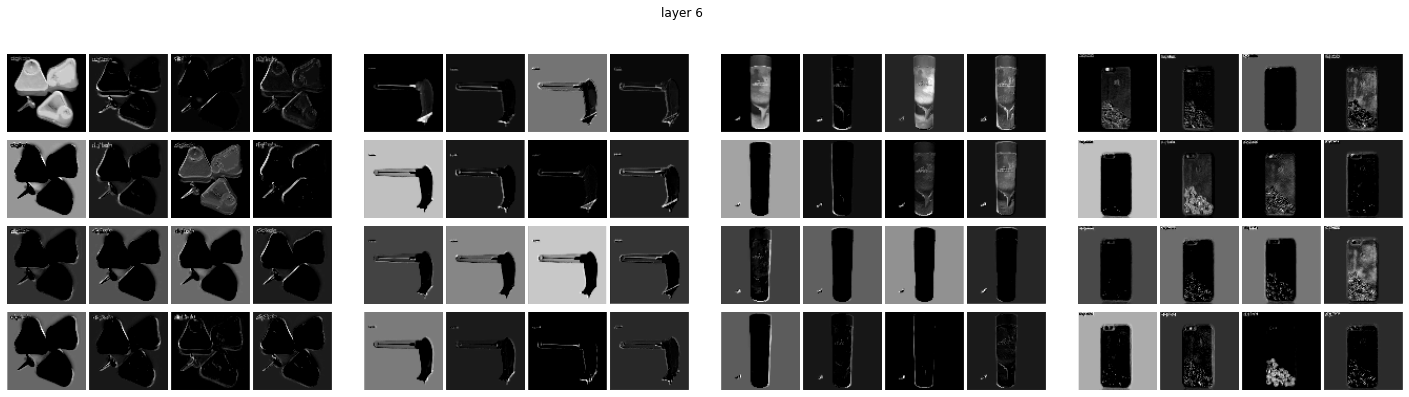

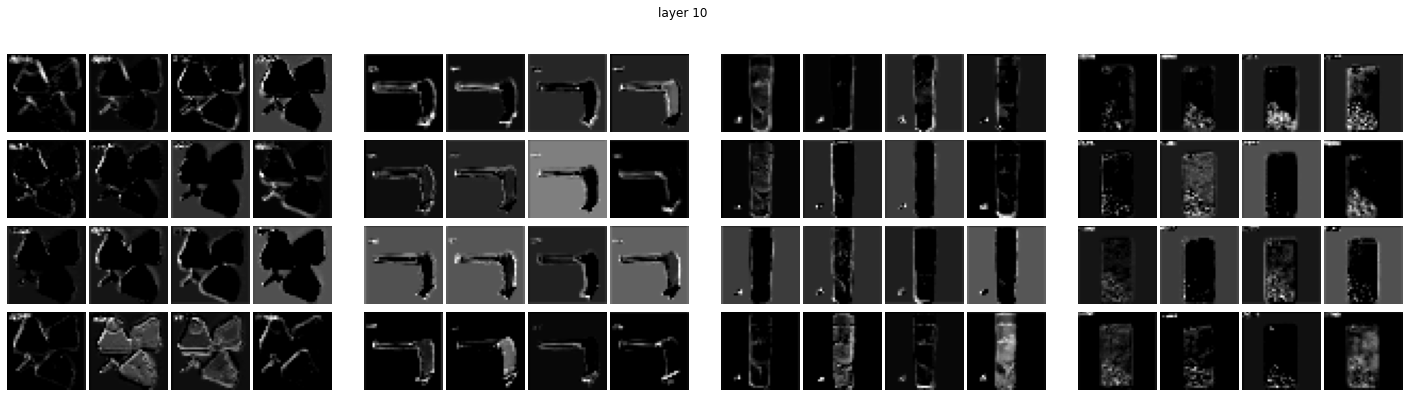

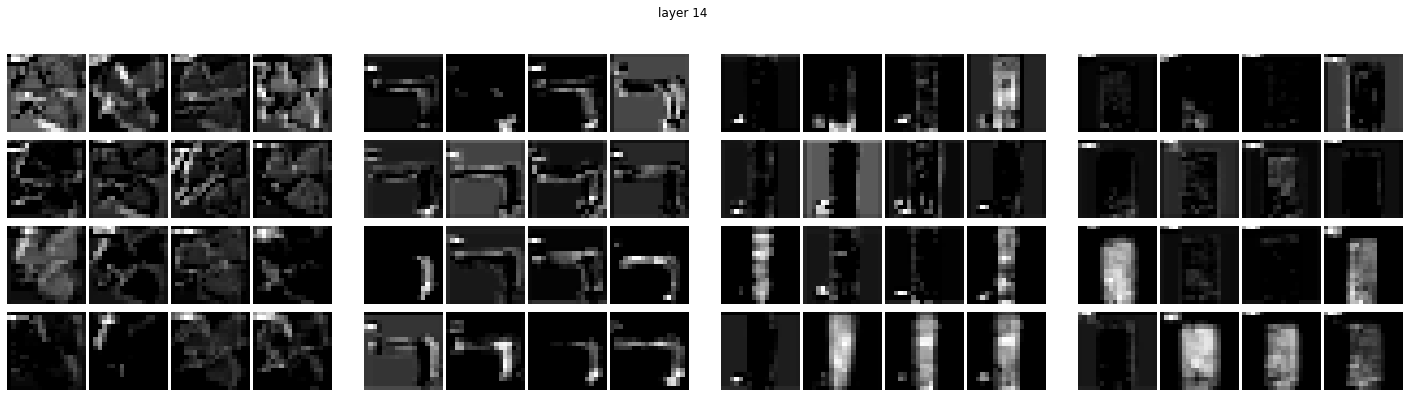

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras.preprocessing import image
from keras.models import Model


def show_feature_maps(model, layer, images):
  temp_model = Model(inputs=model.inputs, outputs=model.layers[layer].output)

  feature_maps = temp_model.predict_on_batch(images)

  fig = plt.figure(figsize=(25, 25 / images.shape[0]))
  fig.suptitle(f'layer {l}')
  outer = gridspec.GridSpec(1, images.shape[0], wspace=0.1, hspace=0)

  square = min(int(np.sqrt(feature_maps.shape[3])), 4)
  for jx, ind in enumerate(feature_maps):
    inner = gridspec.GridSpecFromSubplotSpec(square, square,
                    subplot_spec=outer[jx], wspace=0.05, hspace=0.05)

    ix = 0
    for _ in range(square):
      for _ in range(square):
        ax = plt.Subplot(fig, inner[ix])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("off")
        ax.imshow(feature_maps[jx, :, :, ix-1], cmap='gray')
        fig.add_subplot(ax)
        ix += 1
    
    fig.show()

layer_numbers =  [1, 6, 10, 14]

images_ = [next(iter(train_ds))[0][1], next(iter(train_ds))[0][4], next(iter(val_ds))[0][11], next(iter(val_ds))[0][19]]
images = np.vstack([ np.expand_dims(i, axis=0) for i in images_])

for l in layer_numbers:
  show_feature_maps(model, layer=l, images=images)


## Test

### Define test functions

In [ ]:
from keras.preprocessing import image
import csv

def load_test_images(test_dir):  
  test_images_ = []
  test_images_names = []

  for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    test_images_.append(img)
    test_images_names.append(img_name)
  
  test_images = np.vstack(test_images_)
  return test_images_names, test_images


def write_result_to_csv(predictions, file_name='/content/preds.csv'):
  with open(file_name, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['name', 'predicted'])
    writer.writerows(predictions)
  

### Load Test images

In [ ]:
test_dir = f'{dataset_path}/test'

test_images_names, test_images = load_test_images(test_dir)

### Predict and save results

In [ ]:
predictions_raw = model.predict_on_batch(test_images)

predictions = [(i, (p[0] > 0.5).astype("int32")) for i, p in zip(test_images_names, predictions_raw)]

count = [0, 0]
for i, p in predictions:
  count[p] += 1

write_result_to_csv(predictions)

print("total:", len(test_images), "negative:", count[0], "positive:", count[1])

total: 1103 negative: 633 positive: 470
